# Finite Element Methods for 1D Poisson equation

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.sparse.linalg import spsolve
from scipy.integrate import quadrature
from numpy import sin, cos
from scipy.special import comb

Consider the Poisson equation on the interval $\Omega = (0,1)$

\begin{equation} -u''(x) = f(x) \quad \mbox{in } \Omega,  \qquad u = 0 \quad\mbox{on } \partial \Omega\end{equation}

testing the equation by a function $v\in V = H_{0}^{1}(\Omega) := \{ v\in H^{1}(\Omega): v|_{\partial \Omega} = 0 \}$, and integrating over $\Omega$ we obtain

\begin{equation}
-\int_{\Omega}u'' \,v = \int_{\Omega}f\, v
\end{equation}

We now integrate by parts obtaining the weak formulation of the Poisson problem:  Find $u \in V$ such that

\begin{equation}
a(u,v)= (f,v),\qquad \mbox{where}\quad a(u,v):= \int_{\Omega}u'\,v'\quad \mbox{and}\quad (f,v)_{\Omega}:=\int_{\Omega}f\,v. 
\end{equation}

We will discretize this formulation in order to derive a finite element method.

### Galerkin scheme

We begin by discretizing the space. Consider a finite dimensional space $V_{h}\subset V$. Then, the Galerkin scheme reads as:
Find $u_{h}\in V_{h}$ such that

\begin{equation}
a(u_{h},v) = (f,v),\qquad \mbox{for all } v\in V_{h}.
\end{equation}

Observe that now we have finite dimesional system of equations, where the unknows are the coefficients of $u_h$ in terms of a basis of the space $V_h$. We still do not have a method, we need to choose the the finite dimensional (o finite element space) $V_{h}$. 

We begin the presentation with the classical finite element space of continuous piecewise linear polynomials.

Define first a sequence of points $0=x_0<x_1<...<x_n =1$, which partitioned the domain $\Omega = (0,1)$ into subintervals $K_{j} = (x_{j}, x_{j+1})$, for $j=0,...n-1$ and let

\begin{equation}
h_{j} = |K_{j}| = x_{j+1} - x_j\quad \mbox{for } j=0,...,n-1, \qquad \mbox{and }\quad h =max_{0\leq j\leq n-1} h_{j} 
\end{equation}

Then, let $\mathcal{T}_{h} = \{ K\}_{h}$ the collection of this subintervals.

We now define the continuous piecewise linear finite element space

\begin{equation}
V_{h}^{1} = \{ v\in C(\Omega): v|_{K}\in \mathbb{P}^{1}(K)\,\forall K\in \mathcal{T}_{h} \}
\end{equation}

### Example piecewise linear function:

Consider a uniform partition of the domain $(0,1)$ into $n = 5$ subintervals. We present the plot of a function in the space $V_{h}$.

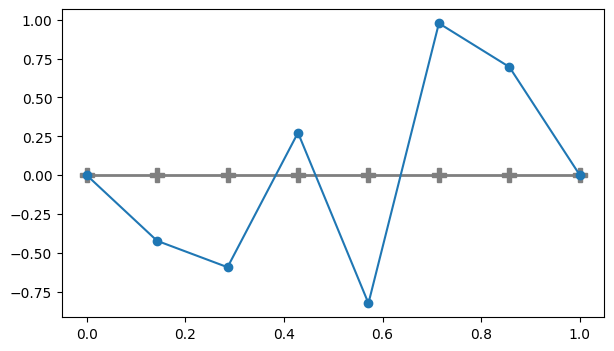

In [2]:
npoints=8
x = np.linspace(0,1,num = npoints);
u = np.hstack([0,-1+2*np.random.rand(npoints-2),0]);
fig1, ax1 = plt.subplots(1,1,figsize=(7,4))
ax1.plot(x, np.zeros(npoints), color='C7', linewidth=2)
ax1.plot(x, np.zeros(npoints), color='C7',marker='P',markersize = 10, linestyle='None')


plt.plot(x,u,'o-')
plt.show();

### Basis of $V_{h}^{1}$.

As it was mentioned early, in order to transform the problem the problem to system of equations we need to decide a basis for the space $V_{h}$. The standard basis is known as the "hat functions", defined by

\begin{equation}
\varphi_{j}\in V_{h}: \qquad \varphi_{j}(x_i) = \delta_{i j} \quad \mbox{for } i,j = 0,...,n
\end{equation}

Note that the support of the basis funcions is $K_{j-1}\cup K_{j}$.

For the previous example, we plot the "hat functions". Observe that $\varphi_0 = \varphi_6 = 0$.

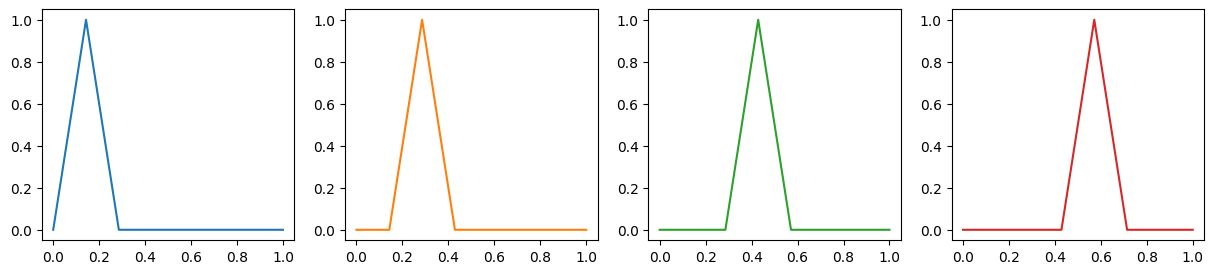

In [3]:
plt.figure(figsize=(15,3))
plt.subplot(141); plt.plot(x,np.array([0,1,0,0,0,0,0,0]),'C0'); #plt.title('$\varphi_1$');
plt.subplot(142); plt.plot(x,np.array([0,0,1,0,0,0,0,0]),'C1'); #plt.title('$\varphi_2$');
plt.subplot(143); plt.plot(x,np.array([0,0,0,1,0,0,0,0]),'C2'); #plt.title('$\varphi_3$');
plt.subplot(144); plt.plot(x,np.array([0,0,0,0,1,0,0,0]),'C3'); #plt.title('$\varphi_4$');

We represent any function $v\in V_{h}$ in the basis by

\begin{equation}
v(x) = \sum_{j=0}^{n} c_{j} \varphi_{j}(x),\quad x\in\Omega.
\end{equation}

Hence, the Galerkin scheme is reduced to the following linear system: Find $u_h = \sum_{j=0}^{n} c_{j} \varphi_{j}\in V_h$ such that $

\begin{equation}
a(u_h,\,\phi_{i}) = (f,\,\varphi_{i})\quad \mbox{for }i=0,...,n
\end{equation}

it a linear system $Ac = b$, where
\begin{equation}
A_{i,j} = a(\varphi_{j},\,\varphi_{i}),\qquad b_{i} = (f,\,\varphi_{i}),\quad \mbox{for }i,j = 0,..,n.
\end{equation}
    


### Uniform grid
Observe that, in the case $h_{j} = h$ for all $j = 0,...,n-1$, we have that

\begin{equation}
a(\varphi_{j}, \,\varphi_{i}) = \int_{\Omega} \varphi_{j}'\,\varphi_{i}' = \left\{ \begin{array}{cl} \frac{2}{h} & \mbox{if } i=j\\\frac{-1}{h}& \mbox{if } i=j-1 \mbox{ or } i = j+1\\
0& \mbox{otherwise}\end{array}\right.
\end{equation}

## Higher order $V_h^{p}$

Let us define the Bernstein polynomial basis of the $\mathcal P_p$ on the interval $(0,1)$

\begin{equation}
B_j^{p}(x) = \binom{p}{k} (1-x)^{p-j}x^{j}, \quad j=0,...,p.
\end{equation}

Note that for the a general interval $(a,b)$ the basis is extended using the barycentric coordinates of the interval, i.e., 
\begin{equation}
\lambda_1(x) = \frac{b-x}{b-a}, \quad \lambda_2(x) = \frac{x-a}{b-a}
\end{equation}
and define the basis of $\mathcal P_p$ on $(a,b)$ by
\begin{equation}
B_{j}^{p}(x) = \binom{p}{j} \lambda_1^{p-j} \lambda_2^{j},\quad j =0,...,p.
\end{equation}

#### Property:
\begin{equation}
\frac{d B_j^{p}(x)}{dx} = p\left( B_{j-1}^{p-1}(x) - B_{j}^{p-1}(x)\right)
\end{equation}

In [4]:
# Bernstein polynomial function
def Bernstein_poly(x,j,p,I):
    if j>=0 and j<=p:
        a = I[0]
        b = I[1]
        lambda1 = (b-x)/(b-a)
        lambda2 = (x-a)/(b-a)
        return comb(p, j)*lambda1**(p-j)*lambda2**j
    else:
        return 0

def dBernstein_poly(x,j,p,I):
    if j>=0 and j<=p:
        a = I[0]
        b = I[1]
        return p*(Bernstein_poly(x,j-1,p-1,I) - Bernstein_poly(x,j,p-1,I))/(b-a)
    else:
        return 0

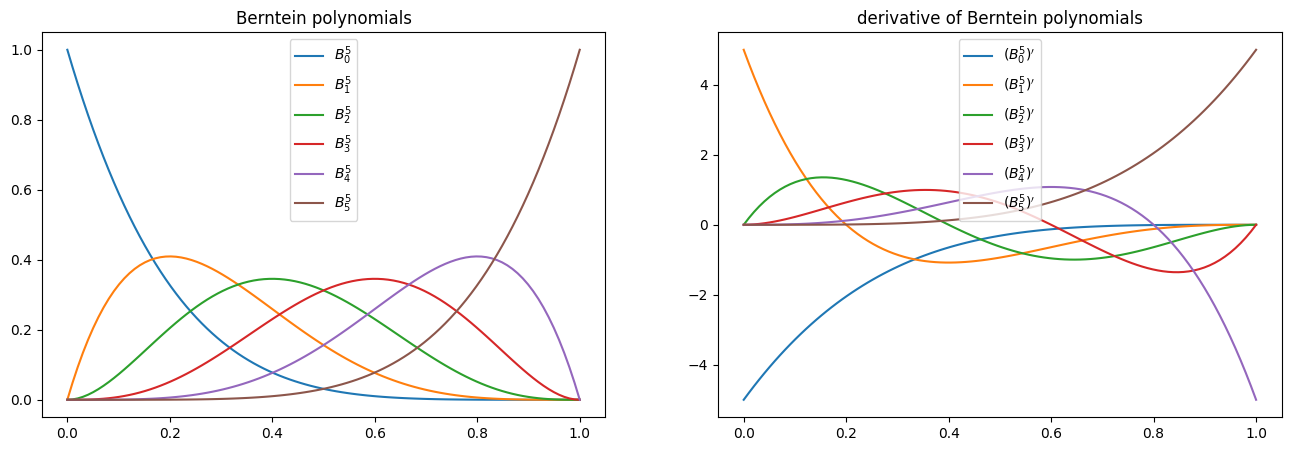

In [5]:
# Plot Bernstein polynomial on (0,1)
p = 5
x = np.linspace(0,1,100) 
fig, ax = plt.subplots(1,2,figsize=(16,5))
for j in range(p+1):
    Bval = Bernstein_poly(x,j,p,[0,1])
    ax[0].plot(x, Bval, label='$B_%i^5$'%j)
    dBval = dBernstein_poly(x,j,p,[0,1])
    ax[1].plot(x, dBval, label='$(B_%i^5)\'$'%j)
# end for
plist = np.arange(p+1)
ax[0].legend()
ax[0].set_title("Berntein polynomials")
ax[1].legend()
ax[1].set_title("derivative of Berntein polynomials")
ax[1].legend(loc=9)
plt.show()

## Computational example

Consider the exact solution of the Poisson problem 
\begin{equation}
u(x) = \sin(2\pi x)
\end{equation}
in $(0,1)$

In [6]:
# 1D FEM for Poisson equation
# -u'' = f in (0,1), u(0) = u(1) = 0
xi = 0; xf = 1;

u  = lambda x: sin(2*np.pi*x)
du = lambda x: 2*np.pi*cos(2*np.pi*x)
f  = lambda x: (2*np.pi)**2*sin(2*np.pi*x)

### Finite element mesh on (0,1)

In [7]:
# Triangulation
def mesh(xi,xf,j):
    n = 2**j;
    Coordinates = np.linspace(xi,xf,num = n+2) # nodes 
    NN = Coordinates.size # number of coordinates or nodes
    Elements = np.vstack([range(n+1), range(1,n+2)]).T
    NE = Elements.shape[0] # number of elements
    h = np.max([abs(Coordinates[j+1] - Coordinates[j]) for j in range(n)]) # parameter of the triangulation
    return Coordinates, Elements, NN, NE, h

### Finite element code 

In [8]:
def fem1d_Poisson(Coordinate,Elements,NN, NE, f, p=1):
    iA = []; jA = []; kA = [];
    
    # Load vector
    b = np.zeros(NN+(p-1)*NE);

    # General Structure of degrees of freedom: [Nodes, faces, interior]
    for j in range(NE):
        # Interval
        K = Coordinates[Elements[j,:]]
    
        # Local stiffness matrix
        AK = np.zeros((p+1,p+1), dtype = np.float64) # AK = integral(phi_i'*phi_j', I_j) 
        for i in range(p+1): # dimension of polynomial space
            dphi_i = lambda x: dBernstein_poly(x,i,p,K)
            for k in range(p+1): # dimension of polynomial space
                dphi_k = lambda x: dBernstein_poly(x,k,p,K)
                func = lambda x: dphi_i(x)*dphi_k(x)
                AK[i,k]+= quadrature(func, K[0], K[1], maxiter=2*(p-1))[0]
            # end for
        # end for
    
        # Local load vector
        bK = np.zeros(p+1);
        for i in range(p+1):
            phi_i = lambda x: Bernstein_poly(x,i,p,K)
            bK[i] += quadrature(lambda x: f(x)*phi_i(x), K[0], K[1])[0]
        # end for
        # Global Assembling
        # nodal degrees of freedom 
        dofn = Elements[j,:]
        # interior degrees of freedom
        dofi = np.arange(NN+(p-1)*j, NN+(p-1)*(j+1))
        dof = np.hstack([ dofn[0], dofi, dofn[1] ])
    
        # assmebling b
        b[dof] = b[dof] + bK
    
        # Sparse assembling of A: A[dof,dof] = AK
        rows = dof; cols = dof
        prod = [(x,y) for x in rows for y in cols];
        iAlocal = [x for (x,y) in prod]
        jAlocal = [y for (x,y) in prod]
        kAlocal = np.reshape(AK, (1,AK.size))
        iA.extend(iAlocal); jA.extend(jAlocal); kA.extend(kAlocal.flatten())
    # end for
    A = sps.coo_matrix(( kA,(iA, jA)), (NN+NE*(p-1),NN+NE*(p-1)), dtype = np.float64)
    return (A, b)

In [9]:
def fem1d_solver(Coordinates, Elements, f, p=1):
    NN = Coordinates.size
    NE = Elements.shape[0]
    # Solve linear system
    (A, b) = fem1d_Poisson(Coordinates, Elements, NN, NE, f, p)
    uh = np.zeros(NN+(p-1)*NE);
    All = range(0,NN+(p-1)*NE)
    Free = np.setdiff1d(All,[0,NN-1]);
    AFree = A.tocsc()[Free, :][:, Free]
    print("size of A", AFree.shape)
    bFree = b[Free]
    uh[Free] = spsolve(AFree, bFree)
    return uh

### Plot of approximate solution at nodes

c:\users\manuel sánchez\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (2) exceeded. Latest difference = 3.000000e+00
  AccuracyWarning)
c:\users\manuel sánchez\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (2) exceeded. Latest difference = 6.000000e+00
  AccuracyWarning)
c:\users\manuel sánchez\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (2) exceeded. Latest difference = 1.200000e+01
  AccuracyWarning)


size of A (17, 17)


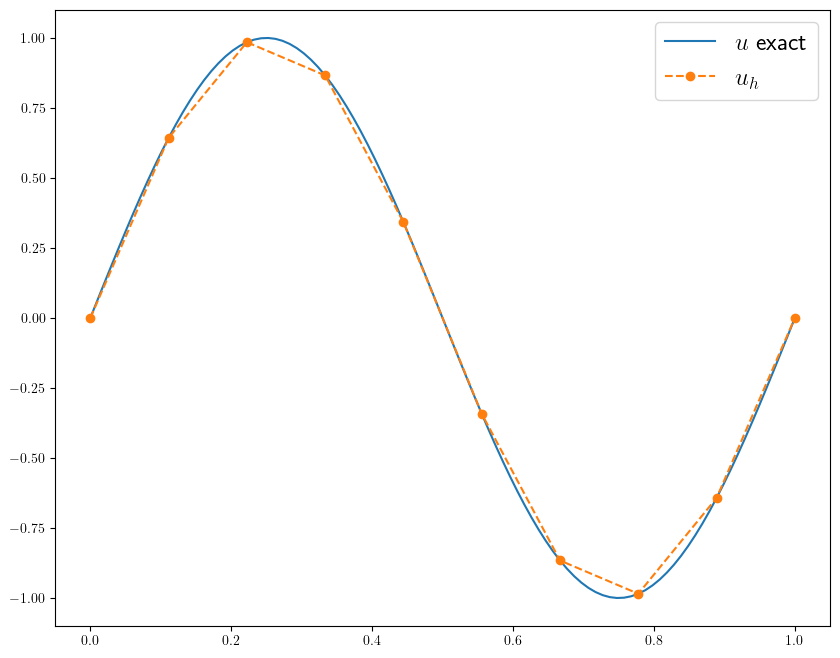

In [10]:
import timeit
plt.rc('text', usetex=True)
Coordinates, Elements, NN, _, _ = mesh(0,1,3)
uh = fem1d_solver(Coordinates, Elements, f, p=2)
x = np.linspace(0,1,100);

fix, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(x, u(x), 'C0', label = r'$u$ exact')
ax.plot(Coordinates,uh[range(NN)], marker = 'o', linestyle ='--', color='C1', label = r'$u_h$') 
#ax.legend(['exact', 'uh at nodes'])
ax.legend(loc='upper right', prop={'size': 18})
plt.show()


### Errors and convergence rate

In [11]:
def uhfun(ui,x,K,p):
    uval = 0
    for j in range(p+1):
        uval+=ui[j]*Bernstein_poly(x,j,p,K)
    # end for
    return uval

def duhfun(ui,x,K,p):
    duval = 0
    for j in range(p+1):
        duval+=ui[j]*dBernstein_poly(x,j,p,K)
    # end for
    return duval

In [12]:
# Compute L^2 and H^1 errors 
# ErrorL2 = || u - uh ||_L2 
# ErrorH1 = || Du - Duh ||_L2
def Compute_errors(Coordinates, Elements, u, du, uh, p):
    NN = Coordinates.size
    NE = Elements.shape[0]
    EL2 = 0; EH1 = 0;
    for j in range(NE):
        K = Coordinates[Elements[j,:]]
        dofn = Elements[j,:]
        dofi = np.arange(NN+(p-1)*j, NN+(p-1)*(j+1))
        dof = np.hstack([ dofn[0], dofi, dofn[1] ])
        uj = uh[dof]
    
        efun2 = lambda x: abs(u(x) - uhfun(uj,x,K,p))**2
        EL2 += quadrature(efun2, K[0], K[1])[0]
    
        defun2 = lambda x: abs(du(x) - duhfun(uj,x,K,p))**2;
        EH1 += quadrature(defun2, K[0], K[1])[0]
    # end for
    EL2 = np.sqrt(EL2)
    EH1 = np.sqrt(EH1)
    return EL2, EH1
def Compute_rates(EL2, EH1, h):
    rEL2 = np.zeros(len(h)); rEH1 = np.zeros(len(h))
    for j in range(4):
        rEL2[j+1] = np.log(EL2[j+1]/EL2[j])/ np.log(h[j+1]/h[j])
        rEH1[j+1] = np.log(EH1[j+1]/EH1[j])/ np.log(h[j+1]/h[j])
    # end for
    return rEL2, rEH1

### Convergence test for space $V_h^p$

In [13]:
# Convergence test
p = 5
EL2 = []; EH1 = []; h = []
for j in range(1,6):
    Coordinates, Elements, _, _ ,hj = mesh(0,1,j)
    uh = fem1d_solver(Coordinates, Elements, f, p)
    EL2j, EH1j = Compute_errors(Coordinates, Elements, u, du, uh, p)
    EL2.append(EL2j); EH1.append(EH1j); h.append(hj)
# end for
rEL2, rEH1 = Compute_rates(EL2, EH1,h)

np.set_printoptions(precision=8, suppress=False, linewidth=sys.maxsize,threshold=sys.maxsize)
print("L2 error:", np.asarray(EL2))
np.set_printoptions(precision=3, suppress=True, linewidth=sys.maxsize,threshold=sys.maxsize)
print("rate L2 :", rEL2)
np.set_printoptions(precision=5, suppress=False, linewidth=sys.maxsize,threshold=sys.maxsize)
print("H1 error:",np.asarray(EH1))
np.set_printoptions(precision=3, suppress=True, linewidth=sys.maxsize,threshold=sys.maxsize)
print("rate H1 :", rEH1)


size of A (14, 14)
size of A (24, 24)
size of A (44, 44)
size of A (84, 84)
size of A (164, 164)
L2 error: [5.26653738e-05 2.52111433e-06 7.48679520e-08 1.65365801e-09 3.09424425e-11]
rate L2 : [0.    5.95  5.983 5.995 5.998]
H1 error: [1.71630e-03 4.44117e-05 2.34646e-06 9.75275e-08 3.53763e-09]
rate H1 : [0.    7.154 5.003 5.001 5.   ]


### Approximation using $V_h^{1}$

|   h      | Error L2      |   order    | Error H1      |   order   | 
|----------|---------------|------------|---------------|-----------|
|    1/3   | 1.665e-02     |     -      | 1.59e-01     |    -      |
|    1/5   | 6.126e-03     |    1.96    | 9.706e-02     |    0.97   | 
|    1/9   | 1.905e-03     |    1.99    | 5.427e-02     |    0.99   | 
|    1/17  | 5.283e-04     |    2.02    | 2.879e-02     |    1.00   |


### Approximation using $V_h^{2}$

|   h      | Error L2      |   order    | Error H1      |   order   | 
|----------|---------------|------------|---------------|-----------|
|    1/3   | 1.079e-03     |     -      | 2.097e-02     |    -      |
|    1/5   | 2.490e-04     |    2.87    | 7.549e-03     |    2.00   | 
|    1/9   | 5.569e-05     |    2.55    | 2.330e-03     |    2.00   | 
|    1/17  | 8.264e-06     |    3.00    | 6.381e-04     |    2.00   |

### Approximation using $V_h^{3}$

|   h      | Error L2      |   order    | Error H1      |   order   | 
|----------|---------------|------------|---------------|-----------|
|    1/3   | 2.024e-05     |     -      | 8.260e-04     |    -      |
|    1/5   | 2.625e-06     |    3.98    | 1.820e-04     |    2.96   | 
|    1/9   | 2.536e-07     |    3.99    | 3.163e-05     |    2.98   | 
|    1/17  | 1.995e-08     |    4.00    | 4.700e-06     |    3.00   |

### Approximation using $V_h^{4}$

|   h      | Error L2      |   order    | Error H1      |   order   | 
|----------|---------------|------------|---------------|-----------|
|    1/3   | 6.614e-07     |     -      | 4.814e-05     |    -      |
|    1/5   | 5.135e-08     |    5.00    | 6.227e-06     |    4.00   | 
|    1/9   | 2.716e-09     |    5.00    | 5.928e-07     |    4.00   | 
|    1/17  | 1.129e-10     |    5.00    | 4.656e-08     |    4.00   |

### Approximation using $V_h^{5}$

|   h      | Error L2      |   order    | Error H1      |   order   | 
|----------|---------------|------------|---------------|-----------|
|    1/3   | 2.100e-08     |     -      | 2.191e-07     |    -      |
|    1/5   | 9.888e-10     |    5.98    | 1.715e-08     |    4.99   | 
|    1/9   | 2.916e-11     |    6.00    | 9.098e-10     |    5.00   | 
|    1/17  | 6.434e-13     |    6.00    | 3.789e-11     |    5.00   |


# Static condensation

In [14]:
# Stiffnes Matrix for coo_sparse matrix: A = sps.coo_matrix((NN+(p-1)*NE, NN+(p-1)*NE), dtype=np.float64)
def fem1d_solver_static_condensation(Coordinates, Elements, f, p=1):
    iS = []; jS = []; kS = [];
    NN = Coordinates.size
    NE = Elements.shape[0]
    
    # Load vector
    bs= np.zeros(NN+(p-1)*NE);

    # General Structure of degrees of freedom: [Nodes, faces, interior]
    for j in range(NE):
        # Interval
        K = Coordinates[Elements[j,:]]
    
        # Local stiffness matrix
        AK = np.zeros((p+1,p+1), dtype = np.float64) # AK = integral(phi_i'*phi_j', I_j) 
        

        for i in range(p+1): # dimension of polynomial space
            dphi_i = lambda x: dBernstein_poly(x,i,p,K)
            for k in range(p+1): # dimension of polynomial space
                dphi_k = lambda x: dBernstein_poly(x,k,p,K)
                func = lambda x: dphi_i(x)*dphi_k(x)
                AK[i,k]+= quadrature(func, K[0], K[1], maxiter=2*(p-1))[0]
            # end for
        # end for
        
        # Local load vector
        bK = np.zeros(p+1);
        for i in range(p+1):
            phi_i = lambda x: Bernstein_poly(x,i,p,K)
            bK[i] += quadrature(lambda x: f(x)*phi_i(x), K[0], K[1])[0]
        # end for
        
        # static condensation
        A00 = AK[ 1:p, :][:,1:p]
        A0p = AK[1:p,:][:,[0,p]]
        Ap0 = AK[[0,p],:][:,1:p]
        App = AK[[0,p],:][:,[0,p]]
        bp = bK[[0,p]]
        b0 = bK[1:p]
        G  = np.linalg.solve(A00, A0p).T
        SK  = App-G@A0p
        bsK = bp - G.dot(b0) 
    
    
        
        # Global Assembling
        # nodal degrees of freedom 
        dofn = Elements[j,:]
        # interior degrees of freedom
        #dofi = np.arange(NN+(p-1)*j, NN+(p-1)*(j+1))
        #dof = np.hstack([ dofn[0], dofi, dofn[1] ])
    
        # assmebling b
        bs[dofn] += bsK
    
        # Sparse assembling of A: A[dof,dof] = AK
        rows = dofn; cols = dofn
        prod = [(x,y) for x in rows for y in cols];
        iSlocal = [x for (x,y) in prod]
        jSlocal = [y for (x,y) in prod]
        kSlocal = np.reshape(SK, (1,SK.size))
        iS.extend(iSlocal); jS.extend(jSlocal); kS.extend(kSlocal.flatten())
    # end for
    S = sps.coo_matrix(( kS,(iS, jS)), (NN,NN), dtype = np.float64)

    # Solve linear system
    uhnodes = np.zeros(NN);
    All = range(0,NN)
    Free = np.setdiff1d(All,[0,NN-1]);
    SFree = S.tocsc()[Free, :][:, Free]
    print("size of S", SFree.shape)
    bsFree = bs[Free]
    %time uhnodes[Free] = spsolve(SFree, bsFree)
    return uhnodes

size of S (1024, 1024)
Wall time: 0 ns


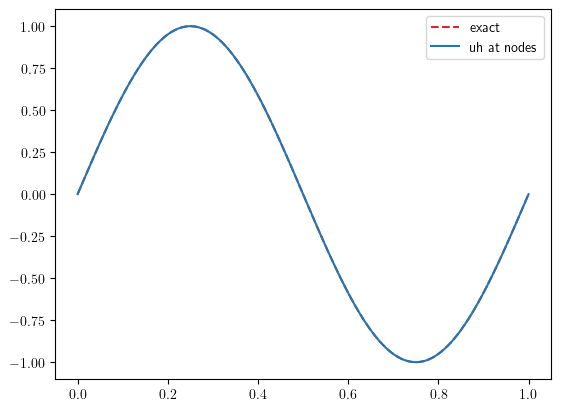

In [15]:
Coordinates, Elements, NN, _,_ = mesh(0,1,10)
uh = fem1d_solver_static_condensation(Coordinates, Elements, f, p=10)
x = np.linspace(0,1,100);
plt.plot(x, u(x), '--C3');
plt.plot(Coordinates,uh[range(NN)], 'C0'); 
plt.legend(['exact', 'uh at nodes'])
plt.show();

# 2D case

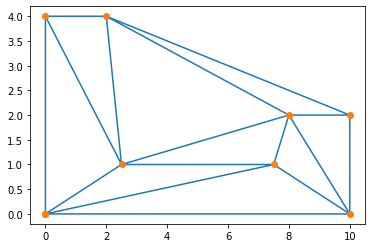

In [235]:
# Create list of polygonal domain vertices

domain_vertices = np.array([ [0.0, 0.0],
                             [10.0, 0.0],
                             [10.0, 2.0],
                             [8.0, 2.0],
                             [7.5, 1.0],
                             [2.5, 1.0],
                             [2.0, 4.0],
                             [0.0, 4.0],
                             [0.0, 0.0]]);

triangles0 = np.array([])
#print(domain_vertices)
triang = mtri.Triangulation(domain_vertices[:,0], domain_vertices[:,1]);

plt.triplot(triang, marker="o")
plt.show()

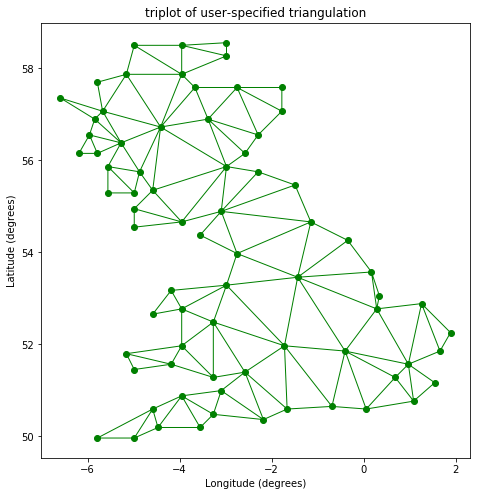

In [267]:
xy = np.asarray([
    [-0.101, 0.872], [-0.080, 0.883], [-0.069, 0.888], [-0.054, 0.890],
    [-0.045, 0.897], [-0.057, 0.895], [-0.073, 0.900], [-0.087, 0.898],
    [-0.090, 0.904], [-0.069, 0.907], [-0.069, 0.921], [-0.080, 0.919],
    [-0.073, 0.928], [-0.052, 0.930], [-0.048, 0.942], [-0.062, 0.949],
    [-0.054, 0.958], [-0.069, 0.954], [-0.087, 0.952], [-0.087, 0.959],
    [-0.080, 0.966], [-0.085, 0.973], [-0.087, 0.965], [-0.097, 0.965],
    [-0.097, 0.975], [-0.092, 0.984], [-0.101, 0.980], [-0.108, 0.980],
    [-0.104, 0.987], [-0.102, 0.993], [-0.115, 1.001], [-0.099, 0.996],
    [-0.101, 1.007], [-0.090, 1.010], [-0.087, 1.021], [-0.069, 1.021],
    [-0.052, 1.022], [-0.052, 1.017], [-0.069, 1.010], [-0.064, 1.005],
    [-0.048, 1.005], [-0.031, 1.005], [-0.031, 0.996], [-0.040, 0.987],
    [-0.045, 0.980], [-0.052, 0.975], [-0.040, 0.973], [-0.026, 0.968],
    [-0.020, 0.954], [-0.006, 0.947], [ 0.003, 0.935], [ 0.006, 0.926],
    [ 0.005, 0.921], [ 0.022, 0.923], [ 0.033, 0.912], [ 0.029, 0.905],
    [ 0.017, 0.900], [ 0.012, 0.895], [ 0.027, 0.893], [ 0.019, 0.886],
    [ 0.001, 0.883], [-0.012, 0.884], [-0.029, 0.883], [-0.038, 0.879],
    [-0.057, 0.881], [-0.062, 0.876], [-0.078, 0.876], [-0.087, 0.872],
    [-0.030, 0.907], [-0.007, 0.905], [-0.057, 0.916], [-0.025, 0.933],
    [-0.077, 0.990], [-0.059, 0.993]])
x = np.degrees(xy[:, 0])
y = np.degrees(xy[:, 1])

triangles = np.asarray([
    [67, 66,  1], [65,  2, 66], [ 1, 66,  2], [64,  2, 65], [63,  3, 64],
    [60, 59, 57], [ 2, 64,  3], [ 3, 63,  4], [ 0, 67,  1], [62,  4, 63],
    [57, 59, 56], [59, 58, 56], [61, 60, 69], [57, 69, 60], [ 4, 62, 68],
    [ 6,  5,  9], [61, 68, 62], [69, 68, 61], [ 9,  5, 70], [ 6,  8,  7],
    [ 4, 70,  5], [ 8,  6,  9], [56, 69, 57], [69, 56, 52], [70, 10,  9],
    [54, 53, 55], [56, 55, 53], [68, 70,  4], [52, 56, 53], [11, 10, 12],
    [69, 71, 68], [68, 13, 70], [10, 70, 13], [51, 50, 52], [13, 68, 71],
    [52, 71, 69], [12, 10, 13], [71, 52, 50], [71, 14, 13], [50, 49, 71],
    [49, 48, 71], [14, 16, 15], [14, 71, 48], [17, 19, 18], [17, 20, 19],
    [48, 16, 14], [48, 47, 16], [47, 46, 16], [16, 46, 45], [23, 22, 24],
    [21, 24, 22], [17, 16, 45], [20, 17, 45], [21, 25, 24], [27, 26, 28],
    [20, 72, 21], [25, 21, 72], [45, 72, 20], [25, 28, 26], [44, 73, 45],
    [72, 45, 73], [28, 25, 29], [29, 25, 31], [43, 73, 44], [73, 43, 40],
    [72, 73, 39], [72, 31, 25], [42, 40, 43], [31, 30, 29], [39, 73, 40],
    [42, 41, 40], [72, 33, 31], [32, 31, 33], [39, 38, 72], [33, 72, 38],
    [33, 38, 34], [37, 35, 38], [34, 38, 35], [35, 37, 36]])

# Rather than create a Triangulation object, can simply pass x, y and triangles
# arrays to triplot directly.  It would be better to use a Triangulation object
# if the same triangulation was to be used more than once to save duplicated
# calculations.
plt.figure(figsize=(10,8))
plt.gca().set_aspect('equal')
plt.triplot(x, y, triangles, 'go-', lw=1.0)
plt.title('triplot of user-specified triangulation')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

plt.show()

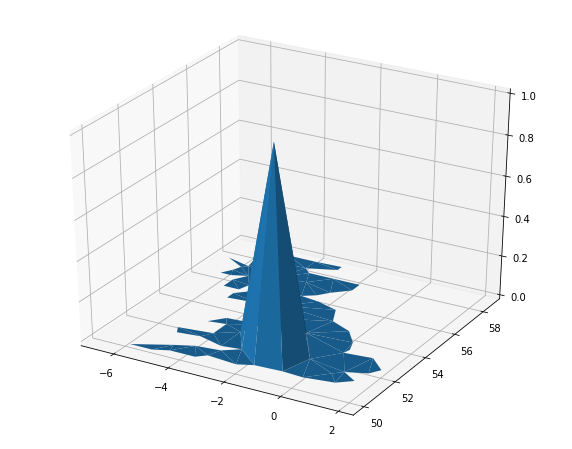

In [266]:
from mpl_toolkits.mplot3d import Axes3D
uh = np.zeros(triangles.shape[0])
uh[68]=1
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.plot_trisurf(x,y, triangles, uh)
plt.show()

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


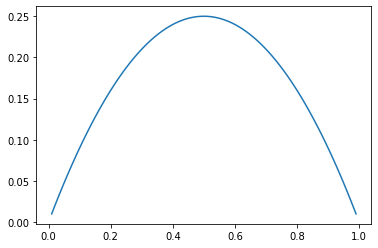

In [25]:
import numpy as np
import matplotlib.pyplot as plt
#A = np.array((100,100))
n = 99
A = 2*np.diag(np.ones(n))-np.diag(np.ones(n-1),-1)-np.diag(np.ones(n-1),1)
b = 2*np.ones(n)/(n+1)**2
t = np.linspace(0, 1, n+2)
print(t)
x = np.linalg.solve(A,b)
plt.plot(t[1:-1],x )

[0.    0.333 0.667 1.   ] 3


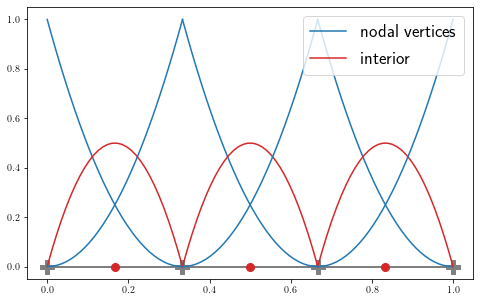

In [68]:
fig, ax = plt.subplots(1,1,figsize = (8,5))
Coordinates, Elements, NN, NE,_ = mesh(0,1,1)
midpoints = [0.5*(Coordinates[j+1]+Coordinates[j]) for j in range(NE)]
plt.rc('text', usetex=True)
line1,  = ax.plot(Coordinates, np.zeros(NN), color='C7', linewidth=2)
line1_s,= ax.plot(Coordinates, np.zeros(NN), color='C7',marker='P',markersize = 14, linestyle='None')
line1_m,= ax.plot(midpoints, np.zeros(NE), color='C3',marker='o',markersize = 8, linestyle='None')




print(Coordinates, NE)
xplot = np.linspace(0,1,100)
p = 2

I1 = Coordinates[Elements[0,:]]
xplotI1 = np.linspace(I1[0],I1[1],30)
B0 = lambda x: Bernstein_poly(x,0,p,I1)
B4 = lambda x: Bernstein_poly(x,1,p,I1)
B1 = lambda x: Bernstein_poly(x,2,p,I1)
ax.plot(xplotI1,B0(xplotI1), 'C0')
ax.plot(xplotI1,B4(xplotI1), 'C3')
ax.plot(xplotI1,B1(xplotI1), 'C0',)

I2 = Coordinates[Elements[1,:]]
xplotI2 = np.linspace(I2[0],I2[1],30)
B1 = lambda x: Bernstein_poly(x,0,p,I2)
B5 = lambda x: Bernstein_poly(x,1,p,I2)
B2 = lambda x: Bernstein_poly(x,2,p,I2)
ax.plot(xplotI2,B1(xplotI2), 'C0')
ax.plot(xplotI2,B5(xplotI2), 'C3')
ax.plot(xplotI2,B2(xplotI2), 'C0')

I3 = Coordinates[Elements[2,:]]
xplotI3 = np.linspace(I3[0],I3[1],30)
B2 = lambda x: Bernstein_poly(x,0,p,I3)
B6 = lambda x: Bernstein_poly(x,1,p,I3)
B3 = lambda x: Bernstein_poly(x,2,p,I3)
ax.plot(xplotI3,B2(xplotI3), 'C0', label='nodal vertices')
ax.plot(xplotI3,B6(xplotI3), 'C3', label='interior')
ax.plot(xplotI3,B3(xplotI3), 'C0')
ax.legend(prop={'size': 18})
plt.show()

In [84]:
from mpl_toolkits.mplot3d import Axes3D 

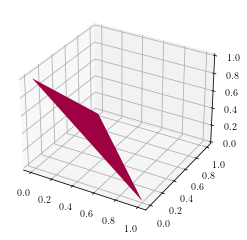

In [89]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1,1, projection='3d')
ax.plot_trisurf([0,1,0], [0,0,1], [1,0,0],triangles=[0,1,2], cmap=plt.cm.Spectral)
plt.show()

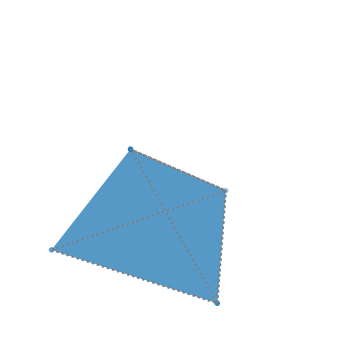

In [122]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
fig.patch.set_visible(False)
ax.axis('off')
x = [0, 2, 1, 1]
y = [0, 0, 1, 0]
z = [0, 0, 0, 1]

vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

tupleList = list(zip(x, y, z))

poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
ax.scatter(x,y,z)
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='C0', linewidths=1, alpha=0.5))
ax.add_collection3d(Line3DCollection(poly3d, colors='C7', linewidths=2, linestyles=':'))
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
plt.show()

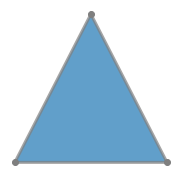

In [118]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
x = [0, 2, 1, 0]
y = [0, 0, 1.5, 0]
ax.plot(x[:3],y[:3], 'o', color='C7')
ax.fill(x, y, facecolor='C0', edgecolor='C7', linewidth=3, alpha=0.7)
fig.patch.set_visible(False)
ax.axis('off')
plt.show()

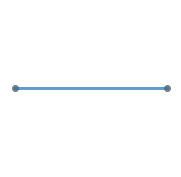

In [121]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
x = [0, 1]
y = [0, 0]
ax.plot(x[:2],y[:2], 'o', color='C7')
ax.plot(x, y, color='C0',linewidth=3, alpha=0.7)
fig.patch.set_visible(False)
ax.axis('off')
plt.show()